In [1]:
# import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, LeakyReLU

In [2]:
# load data
BTC = pd.read_csv('..\\Data\\BTC_clean.csv')
BTC.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1873 entries, 0 to 1872
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Date       1873 non-null   object 
 1   Open       1873 non-null   float64
 2   High       1873 non-null   float64
 3   Low        1873 non-null   float64
 4   Close      1873 non-null   float64
 5   Adj Close  1873 non-null   float64
 6   Volume     1873 non-null   float64
dtypes: float64(6), object(1)
memory usage: 102.6+ KB


In [3]:
# create adj_close df and apply MinMaxScaler to normalize prices
a_close = BTC[['Adj Close']]
MinMaxScaler = MinMaxScaler()
norm_a_close = MinMaxScaler.fit_transform(a_close.values)

In [4]:
# function to create data and labels, reshape data
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size

  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    
    # reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
    
  return np.array(data), np.array(labels)

In [5]:
# split into test and train sets
past_history = 3
future_target = 0
split = int(len(a_close)*.8)

x_train, y_train = univariate_data(norm_a_close, 0, split, past_history, future_target)
x_test, y_test = univariate_data(norm_a_close, split, None, past_history, future_target)

x_train.shape

(1495, 3, 1)

In [6]:
# initialize the RNN
model = Sequential()
model.add(LSTM(64, activation = 'sigmoid', input_shape = (None, 1)))
model.add(LeakyReLU(0.5))
model.add(Dropout(0.2))
model.add(Dense(1))

# compile RNN
model.compile(optimizer = 'Adam', loss = 'mse')

In [7]:
# fit the model on the training set
history = model.fit(x_train, y_train, validation_split = 0.1, epochs = 150, batch_size = 10, verbose = 0, shuffle = False)

In [8]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 64)                16896     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________


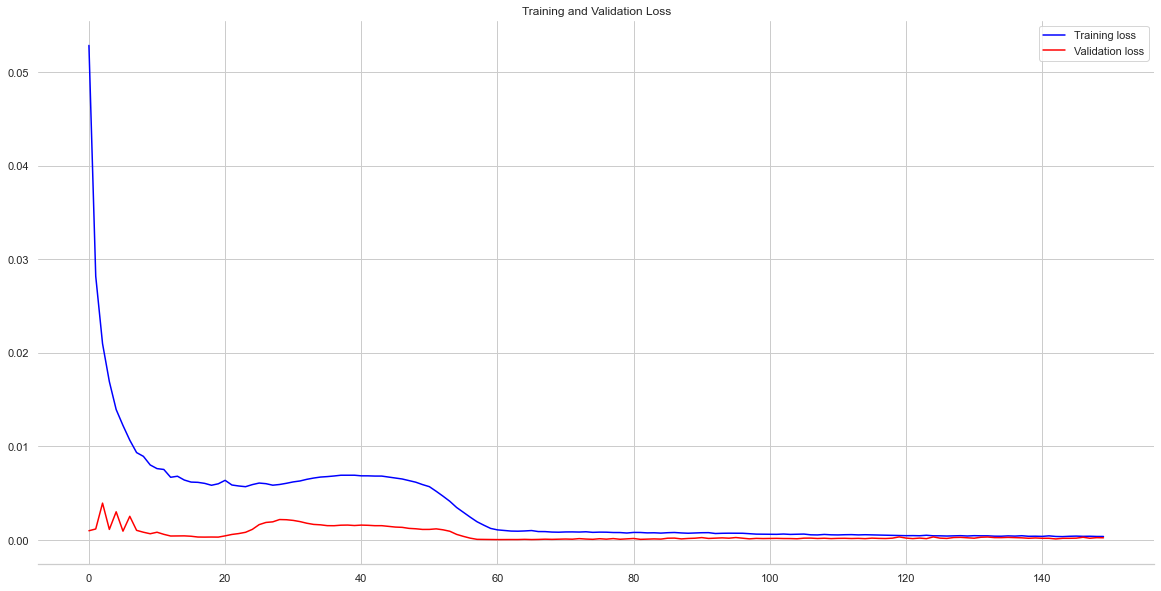

In [9]:
# plot loss and val_loss
sns.set_theme(style = 'whitegrid')
loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize = (20, 10))

plt.plot(range(150), loss, 'blue', label = 'Training loss')
plt.plot(range(150), val_loss, 'red', label = 'Validation loss')
plt.title("Training and Validation Loss")
sns.despine(left = True)
plt.legend()
plt.show()

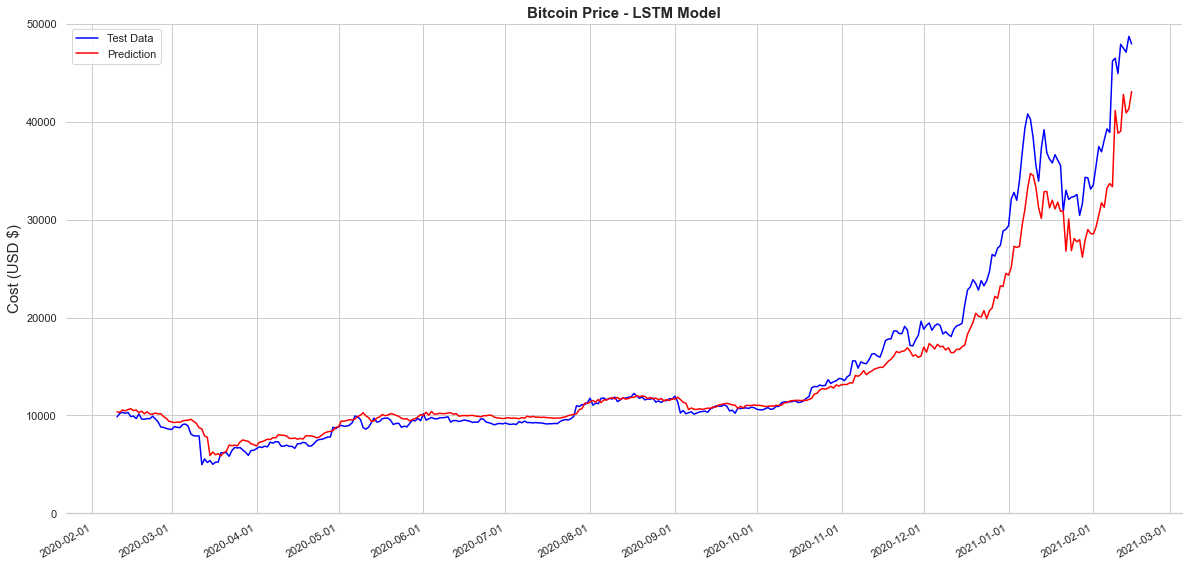

In [10]:
# make DataFrames for predicted and actual prices and dates
actual = pd.DataFrame(MinMaxScaler.inverse_transform(y_test))
predictions = pd.DataFrame(MinMaxScaler.inverse_transform(model.predict(x_test)))
plot_date = pd.DataFrame(BTC['Date'][1501:]).reset_index(drop = True)

# clean up dfs
actual['Date'] = plot_date['Date']
actual.Date = pd.to_datetime(actual.Date)
actual.rename(columns = {0: 'Act_Price'}, inplace = True)
predictions['Date'] = plot_date['Date']
predictions.Date = pd.to_datetime(predictions.Date)
predictions.rename(columns = {0: 'Pred_Price'}, inplace = True)

# plot actuals and preds
plt.subplots(figsize = (20, 10))
ax = sns.lineplot(x = actual['Date'], y = actual.Act_Price, label = "Test Data", color = 'blue')
ax = sns.lineplot(x = predictions['Date'], y = predictions.Pred_Price, label = "Prediction", color = 'red')
ax.set_title('Bitcoin Price - LSTM Model', size = 15, fontweight = 'bold')
ax.set_ylabel("Cost (USD $)", size = 15)
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonthday = 1))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
plt.gcf().autofmt_xdate() # Rotation
ax.set_xlabel(None)
ax.set_ylim([0, 50000])
sns.despine(left = True)
plt.show()

In [11]:
# merge and clean up dfs
df_comp = actual.merge(predictions, how = 'left', on = 'Date')
df_comp = df_comp[['Date', 'Pred_Price', 'Act_Price']]
df_comp['Diff'] = df_comp.Pred_Price - df_comp.Act_Price
df_comp.head()

,Date,Pred_Price,Act_Price,Diff
0,2020-02-10,10370.243164,9856.611328,513.631836
1,2020-02-11,10322.517578,10208.236328,114.281250
2,2020-02-12,10556.371094,10326.054688,230.316406
3,2020-02-13,10471.796875,10214.379883,257.416992
4,2020-02-14,10602.666992,10312.116211,290.550781


In [12]:
# review variances
df_comp.describe()

,Pred_Price,Act_Price,Diff
count,372.000000,372.000000,372.000000
mean,13834.099609,14608.278878,-774.180516
std,7573.966797,9657.240476,2263.989199
min,5881.686035,4970.788086,-12837.257813
25%,9769.833740,9192.341308,-1292.040772
50%,10935.938965,10651.233399,187.145264
75%,14856.137939,16286.709961,547.011230
max,43067.835938,48717.289063,3664.710937
